## Forage de données - TP1

In [551]:
# imports

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk

from pandas.api.types import is_object_dtype, is_numeric_dtype
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.spatial import distance, distance_matrix


# plots settings
%matplotlib inline

sns.set(color_codes=True)
sns.set_palette(sns.color_palette('muted'))

import warnings
warnings.filterwarnings('ignore')

### 1. Représentation des données

In [552]:
# loading datas
data = pd.read_excel("QSAR_dataset.xlsx")
data.head()

# global variables
n_data, n_features = data.shape
n_classes = 5

In [553]:

# Check features with NA
na_values = data.isnull().sum() / data.shape[0]
na_values[na_values > 0]

# clean the NAs
def drop_na(*features, data = data):
    """
    delete all the lines where a `feature` contains an NA
    """
    data.dropna(subset=features, inplace=True)

def fill_na_with_median(*features, data = data):
    """
    fill the NAs of a `feature` by its median
    """
    for feature in features:
        median = data[feature].median()
        data[feature].fillna(value=median, inplace=True)

drop_na('ASA+', 'ASA-', 'a_heavy', 'a_IC')
fill_na_with_median('vsurf_R', 'vsurf_S', 'vsurf_V')


In [554]:
clean_data = data.iloc[:, 2:]  # remove "object" features (smile and class)

In [555]:
# Select 10 best features
kbest = SelectKBest(f_classif, k = 10)
kbest.fit_transform(clean_data, data["Class"])

best_features = kbest.get_feature_names_out()
data_bf = data[best_features]
data_bf["Class"] = data["Class"]

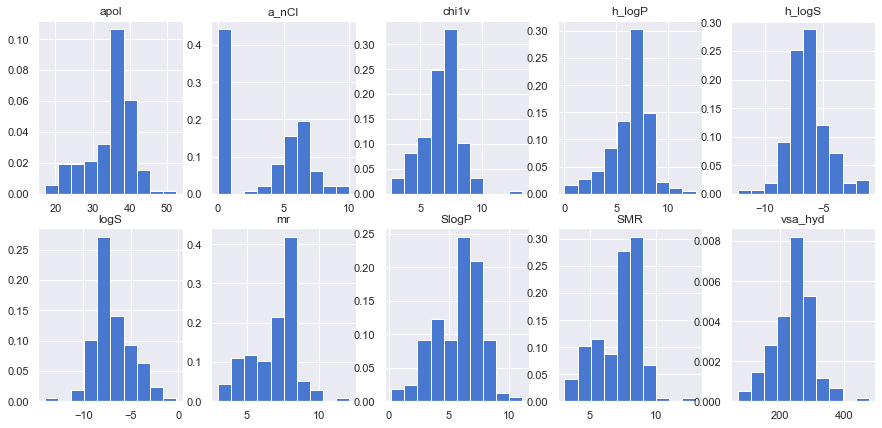

In [556]:
# Visualize the distributions of those 10 features

_, axs = plt.subplots(2, 5, figsize=(15, 7))
for idx, feature in enumerate(best_features):
    row, col = idx // 5, idx % 5

    axs[row, col].hist(data_bf[feature], density=True)
    axs[row, col].set_title(feature)


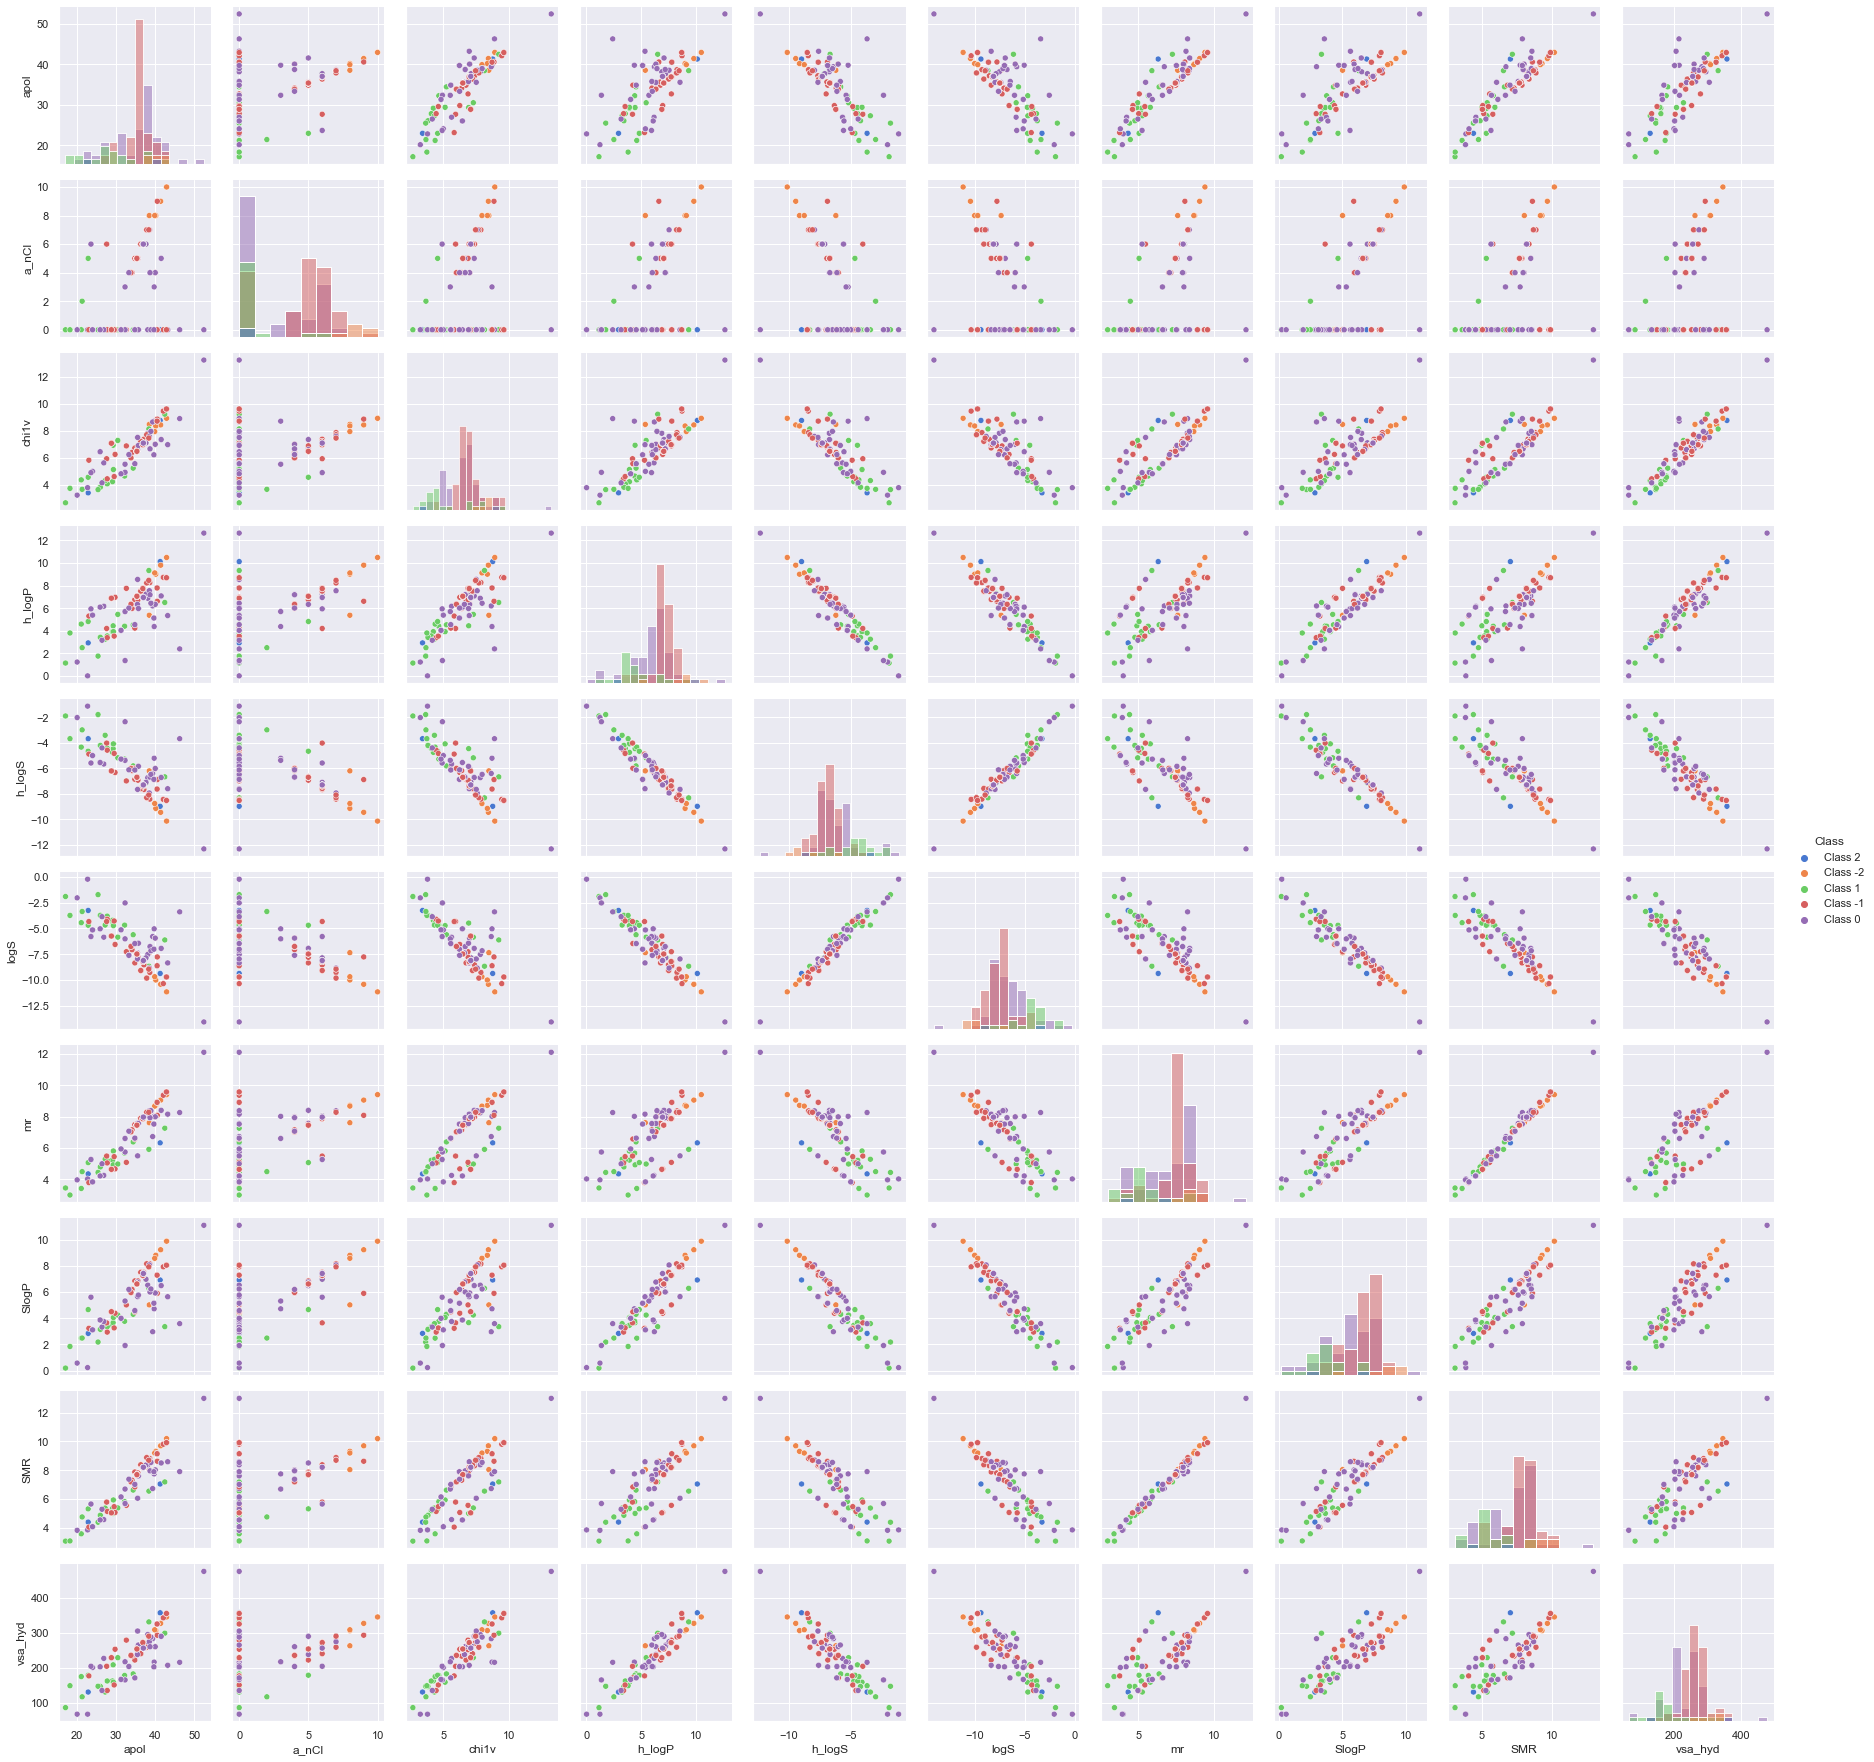

In [557]:
# Visualize correlations and distributions of those features
g = sns.PairGrid(data_bf, hue = "Class")
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend();

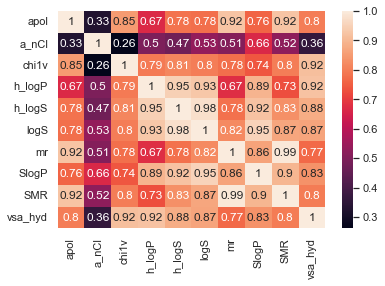

In [558]:
# Correlation of the features
best_features_corr = data_bf.corr()
sns.heatmap(abs(best_features_corr), annot = True);

Des variables sont vraiment corrélées, il est donc pertinent de faire une ACP pour réduire la dimension inutile

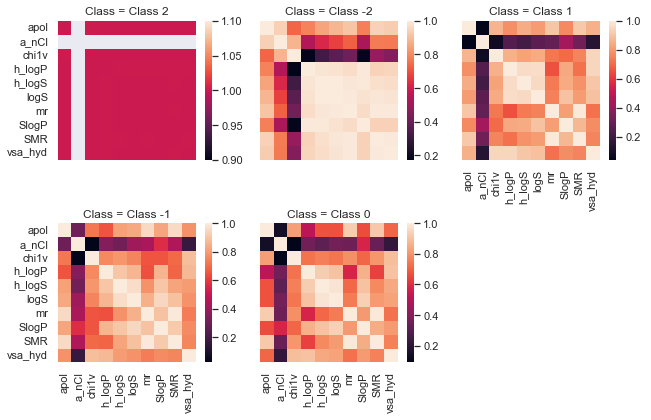

In [559]:
# Correlation of the features, depending on the class
g = sns.FacetGrid(data=data_bf, col="Class", col_wrap=3)
g.map_dataframe(lambda data, color: sns.heatmap(abs(data.corr())))
g.add_legend();


In [560]:
def _nearest_centroid(point, centroids, dist, maha = False, v_matrix = None):
    if maha:
        distances = [dist(point, centroid, v_matrix) for centroid in centroids]
    else:
        distances = [dist(point, centroid) for centroid in centroids]

    return np.argmin(distances)


def assign_to_centroids(points, centroids, dist, maha = False, v_matrix = None):
    return np.array([_nearest_centroid(point, centroids, dist, maha, v_matrix) for point in points])


def rand_index(observed, actual):
    n = len(observed)
    a, b, c, d = 0, 0, 0, 0

    for i in range(n):
        for j in range(i+1, n):
            
            if observed[i] == observed[j]:
                if actual[i] == actual[j]:
                    a += 1
                else:
                    c += 1
            else:
                if actual[i] == actual[j]:
                    d += 1
                else:
                    b += 1
    
    return (a + b) / (a + b + c + d)


def get_centroids(data, *classes):
    
    centroids = []
    for classe in classes:
        if pd.notna(classe):
            data_classe = data.loc[data["Class"] == classe]
            centroid_df = data_classe.mean()
            centroids.append(centroid_df.to_numpy())

    return np.array(centroids)


Analysis with 2 components
--------------------------
RAND index : 0.6118265916923635
explained variance : [0.99294572 0.00400607]


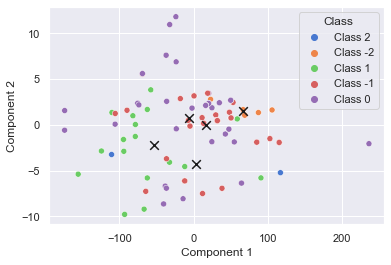

Analysis with 3 components
--------------------------
RAND index : 0.6118265916923635
explained variance : [0.99294572 0.00400607 0.0023471 ]


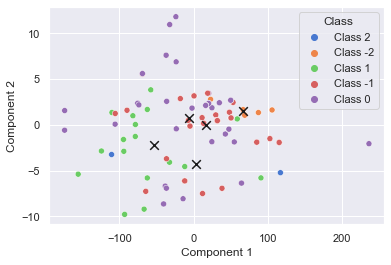

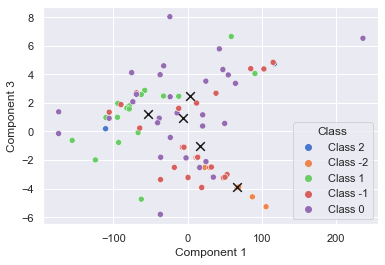

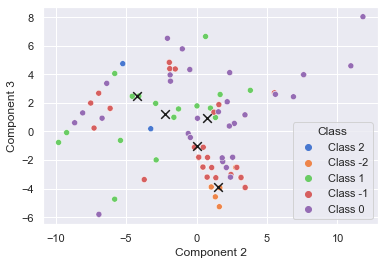

In [561]:

def pca(n_components, dist = distance.euclidean, maha = False, *, show_rand = True, show_variance = True, visualize = True):

    pca_ = PCA(n_components=n_components)
    data_features = data_bf.drop("Class", axis = 1)
    reduced_data = pca_.fit_transform(data_features)
    
    pca_df = pd.DataFrame(reduced_data, columns = [f"Comp {i+1}" for i in range(n_components)])
    pca_df.index = data.index
    pca_df["Class"] = data_bf["Class"].copy()
    
    centroids = get_centroids(pca_df, *pd.unique(pca_df["Class"]))

    v_matrix = np.cov(reduced_data.T) if maha else None
    class_assignation = assign_to_centroids(reduced_data, centroids, dist, maha, v_matrix)

    if show_rand:
        rand = rand_index(class_assignation, data_bf["Class"].to_numpy())
        print(f"RAND index : {rand}")

    if show_variance:
        explained_variance = pca_.explained_variance_ratio_
        print(f"explained variance : {explained_variance}")

    if visualize:
        data_comp = data.copy()
        for i in range(n_components):
            data_comp[f"Comp {i+1}"] = reduced_data[:, i]

        # Components visualization
        for i in range(n_components):
            for j in range(i+1, n_components):

                sns.scatterplot(x=f"Comp {i+1}", y=f"Comp {j+1}", hue="Class", data=data_comp)
                plt.scatter(x = centroids[:, i], y = centroids[:, j], marker="x", s=75, c="k")

                plt.xlabel(f"Component {i+1}")
                plt.ylabel(f"Component {j+1}")
                plt.show()

    return pca_df, pca_


pca_components = [2, 3]
for n_components in pca_components:
    print(f"Analysis with {n_components} components")
    print("--------------------------")
    pca(n_components)


On obtient des performances identiques pour 2 et 3 composantes, c'est que la dernière n'est pas utile (on le voit aussi à sa variance expliquée très faible). On se contentera donc de deux composantes.

### 2. Mesure de distance

In [573]:
distances = [(distance.euclidean, False), (distance.cityblock, False), (distance.mahalanobis, True)]

for dist, maha in distances:
    pca(2, dist, maha, visualize=False, show_variance=False)

RAND index : 0.6118265916923635
RAND index : 0.6118265916923635
RAND index : 0.6115545075276619


### 3. Choix du modèle de classification

k-nn RAND index : 0.7017050607654635
centroids RAND index : 0.6249773263196082


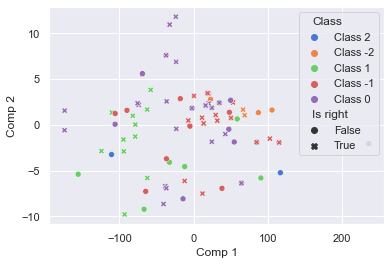

In [563]:
def dist_matrix(points):
    v_matrix = np.cov(points.T)

    return np.array([np.array([distance.mahalanobis(p1, p2, v_matrix) for p1 in points]) for p2 in points])


def knn_prepare_data():
    pca_data, pca_model = pca(2, distance.mahalanobis, True, show_rand = False, show_variance = False, visualize = False)
    points = pca_data.loc[:, pca_data.columns != "Class"].to_numpy()
    d_mat = dist_matrix(points)

    return pca_data, pca_model, points, d_mat


def new_knn(new_point, points, pca_data, pca_model, *, dist_mat = None, idx = None, k = 5):

    if dist_mat is not None:
        dist_to_other_points = dist_mat[idx]
    else:
        v_matrix = np.cov(points.T)
        new_point = new_point.to_numpy().reshape(1, -1)
        new_point = pca_model.transform(new_point)
        
        dist_to_other_points = [
            distance.mahalanobis(new_point, point, v_matrix) for point in points
        ]
        # print(new_point)

    neighbours_sorted = np.argsort(dist_to_other_points)
    k_nearest_neighbours = neighbours_sorted[:k]

    k_nearest_classes = pca_data.iloc[k_nearest_neighbours]
    k_nearest_classes = k_nearest_classes[["Class"]].to_numpy().flatten()

    classes, counts = np.unique(k_nearest_classes, return_counts = True)
    max_idx = np.argmax(counts)

    knn_classe = classes[max_idx]

    return knn_classe



def knn(k = 5, *, show_rand = True, visualize = True):

    pca_data, pca_model, points, d_mat = knn_prepare_data()

    knn_classes = []

    for i in range(len(points)):
        knn_classes.append(
            new_knn(points[i], points, pca_data, pca_model, dist_mat = d_mat, idx = i)
        )

    knn_classes = np.array(knn_classes)

    if show_rand:
        rand = rand_index(knn_classes, pca_data["Class"].to_numpy())
        print(f"k-nn RAND index : {rand}")

    if visualize:
        is_right_data = pca_data.copy()
        is_right = [knn_classes[i] == pca_data["Class"].to_numpy()[i] for i in range(len(knn_classes))]
        is_right_serie = pd.Series(is_right)
        is_right_data["Is right"] = is_right_serie

        sns.scatterplot(x=f"Comp {1}", y=f"Comp {2}", hue="Class", style = "Is right", data=is_right_data)

    return knn_classes



def cost_function(points, centroids, v_matrix, k):
    return sum([
        sum([
            distance.mahalanobis(point, centroids[c], v_matrix)
            for point, classe in points
            if classe == c
        ])
        for c in range(k)
    ])

    


def centroids(k = 5, *, show_rand = True):

    def get_centroids(pts):
        return [
            sum([
                point for point, classe in pts if classe == c
            ]) / max(1, len([point for point, classe in pts if classe == c]))
            for c in range(k)
        ]

    pca_data, _ = pca(2, distance.mahalanobis, True, show_rand = False, show_variance = False, visualize = False)
    points = pca_data.loc[:, pca_data.columns != "Class"].to_numpy()

    # initial centers
    centroids = np.random.choice(pca_data.shape[0], size = k)
    v_matrix = np.cov(points.T)

    classes = assign_to_centroids(points, centroids, distance.mahalanobis, maha = True, v_matrix = v_matrix)

    points_with_classes = list(zip(points, classes))
    score = 0

    eps = 0.000001

    max_n = 1000
    n = 0
    while abs((actual_score := cost_function(points_with_classes, centroids, v_matrix, k)) - score) >= eps:
        n += 1
        if n >= max_n:
            break
        score = actual_score
        centroids = get_centroids(points_with_classes)
        classes = assign_to_centroids(points, centroids, distance.mahalanobis, maha = True, v_matrix = v_matrix)

        points_with_classes = list(zip(points, classes))


    if show_rand:
        rand = rand_index(classes, pca_data["Class"].to_numpy())
        print(f"centroids RAND index : {rand}")

knn()
centroids();





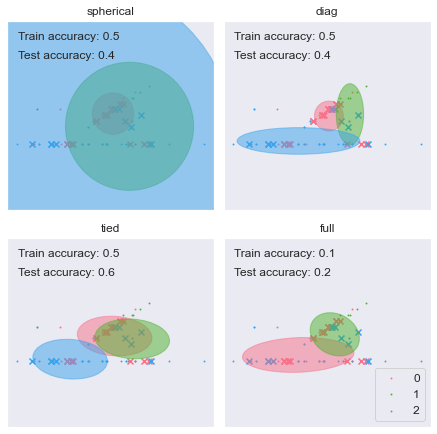

In [564]:
# Author: Ron Weiss <ronweiss@gmail.com>, Gael Varoquaux
# Modified by Thierry Guillemot <thierry.guillemot.work@gmail.com>
# Modified by Aida Ouangraoua <aida.ouangraoua@usherbrooke.com>
# Modified by Nadia Tahiri <Nadia.Tahiri@USherbrooke.com>
# Initial code at https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_covariances.html
import matplotlib as mpl
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split

X_ = data_bf.drop("Class", axis = 1).to_numpy()

classes_to_int = {classe: value for value, classe in enumerate(np.unique(data_bf["Class"].to_numpy()))}
y_ = np.array([
    classes_to_int[classe] for classe in data_bf["Class"].to_numpy()
])

X_train,X_test,y_train,y_test = train_test_split(X_,y_,test_size=0.25,random_state=0)

colors = sns.color_palette("husl",3)

def make_ellipses(gmm, ax):
    for n, color in enumerate(colors):
        if gmm.covariance_type == 'full':
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == 'tied':
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == 'diag':
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == 'spherical':
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        ell = mpl.patches.Ellipse(gmm.means_[n, :2], v[0], v[1],
                                  180 + angle, color=color)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)
        ax.set_aspect('equal', 'datalim')

n_classes = 3

# Try GMMs using different types of covariances.
estimators = {cov_type: GaussianMixture(n_components=n_classes,
              covariance_type=cov_type, max_iter=100, random_state=0)
              for cov_type in ['spherical', 'diag', 'tied', 'full']}

n_estimators = len(estimators)

plt.figure(figsize=(3 * n_estimators // 2, 6))
plt.subplots_adjust(bottom=.01, top=0.95, hspace=.15, wspace=.05,
                    left=.01, right=.99)

for index, (name, estimator) in enumerate(estimators.items()):
    # Since we have class labels for the training data, we can
    # initialize the GMM parameters in a supervised manner.
    estimator.means_init = np.array([X_train[y_train == i].mean(axis=0)
                                    for i in range(n_classes)])

    # Train the other parameters using the EM algorithm.
    estimator.fit(X_train)

    h = plt.subplot(2, n_estimators // 2, index + 1)
    make_ellipses(estimator, h)

    for n, color in enumerate(colors):
        data_ = X_[y_ == n]
        plt.scatter(data_[:, 0], data_[:, 1], s = 0.8, color=color,
                    label=n)
    # Plot the test data with crosses
    for n, color in enumerate(colors):
        data_ = X_test[y_test == n]
        plt.scatter(data_[:, 0], data_[:, 1], marker='x', color=color)

    y_train_pred = estimator.predict(X_train)
    train_accuracy = np.mean(y_train_pred==y_train)#
    plt.text(0.05, 0.9, 'Train accuracy: %.1f' % train_accuracy,
             transform=h.transAxes)

    y_test_pred = estimator.predict(X_test)
    test_accuracy = np.mean(y_test_pred==y_test)
    
    #np.mean(y_test_pred.ravel() == y_test.ravel()) * 100
    plt.text(0.05, 0.8, 'Test accuracy: %.1f' % test_accuracy,
             transform=h.transAxes)

    plt.xticks(())
    plt.yticks(())
    plt.title(name)

plt.legend(scatterpoints=1, loc='lower right', prop=dict(size=12))

plt.show()

### 4. Application

In [575]:
new_data = pd.read_excel("test_TP1.xlsx")
new_data_clean = new_data[best_features]

pca_data, pca_model, points, d_mat = knn_prepare_data()

for i in range(2):
    print(
        new_knn(
            new_data_clean.iloc[i], points, pca_data, pca_model
        )
    )
        



Class 0
Class -1
